In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext skip_cell

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
IMPATIENCE = True

# Extracting features from CNN

We perform transformations that results in images of sizes `(224, 224, 3)`.

In [5]:
from torchvision import transforms
from tmle.dataloaders import ImageFoldersDataset

# define transformations
basic_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])
# define dataset
train_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/train/',
    transform=basic_transforms
)
test_dataset = ImageFoldersDataset(
    path_to_data='../data/cpu/test/',
    transform=basic_transforms
)

Then, we download `ResNet18` with weights pretrained on `ImageNet`.

In [6]:
%%skip $IMPATIENCE
from torchvision import models
from tmle.transformers import CNNFeatures

resnet18 = models.resnet18(pretrained=True)
resnet18_features_extractos = CNNFeatures(
    n_features=512, # what will be a dimension of feature vector
    rm_top_layers=1 # how many top layers will be removed
)
X_resnet18, y_resnet18 = resnet18_features_extractor.extract_features(
    model=resnet18,
    dataset=train_dataset
)

We prepare features for both: train and test sets.

In [7]:
%%skip $IMPATIENCE
from tmle.transformers import CNNFeatures

resnet18_features = CNNFeatures(
    n_features=512, # in final layer
    rm_top_layers=1) # how many top layers will be removed

X_resnet18, y_resnet18 = resnet18_features.extract_features(
    resnet18, train_dataset)
X_resnet18_test, y_resnet18_test = resnet18_features.extract_features(
    resnet18, test_dataset)

## ResNet18

In [8]:
EXPERIMENT_NAME = 'resnet18_svm_v2'

In [9]:
X_resnet18, y_resnet18 = np.load('../data/X_resnet18.npy'), np.load('../data/y_resnet18.npy')

## Hyperparameters tuning

In [11]:
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

space = dict()
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space['C'] = hp.uniform('C', 0.0001, 0.1)

In [12]:
from tmle.model_selection import ClassifierOptimizer
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

clf_optim = ClassifierOptimizer(
    classifier=LinearSVC(
        max_iter=20000,
        random_state=42,
        dual=False,
        verbose=1
    ),
    space=space,
    metric=balanced_accuracy_score
)

In [13]:
%%skip $IMPATIENCE
import warnings
warnings.filterwarnings("ignore")

clf_optim.find_best_params(
    X_resnet18,
    y_resnet18,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=10,
    overfit_penalty=0.1
)

Import and examine results of experiments.

In [14]:
import pickle

trials_path = os.path.join('../experiments/', 'resnet18_svm.hpopt')
with open(trials_path, 'rb') as trials:
    trials = pickle.load(trials)

Evaluate hyperparameters space.

In [15]:
experiments = clf_optim.evaluate_experiments(trials.trials)\
    .fillna(value='None')\
    .assign(train_valid_diff = lambda x: x.train - x.valid)

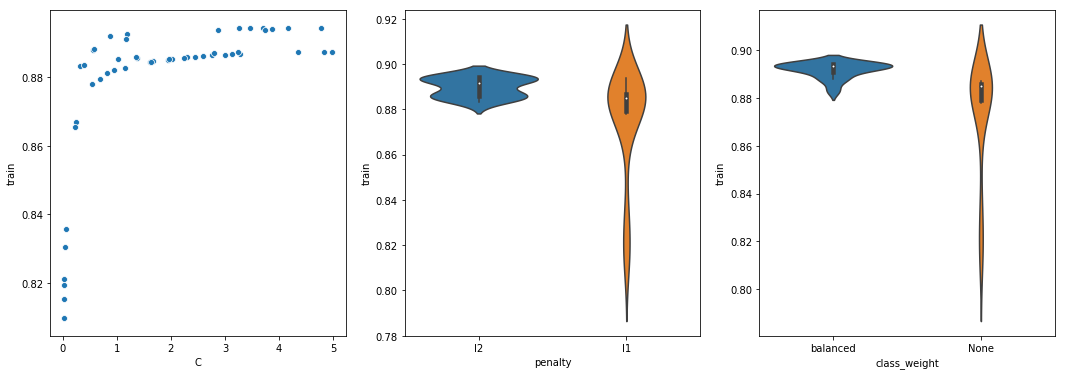

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='train', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='train', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='train', data=experiments, ax=ax[2])

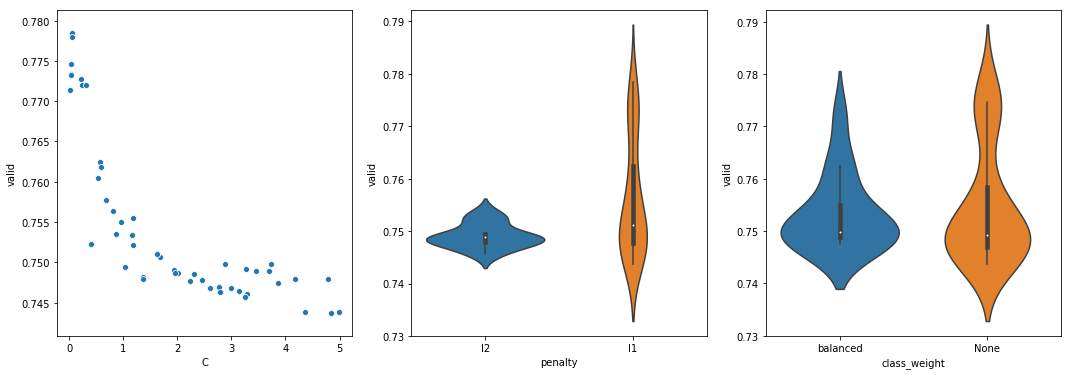

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='valid', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='valid', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='valid', data=experiments, ax=ax[2])

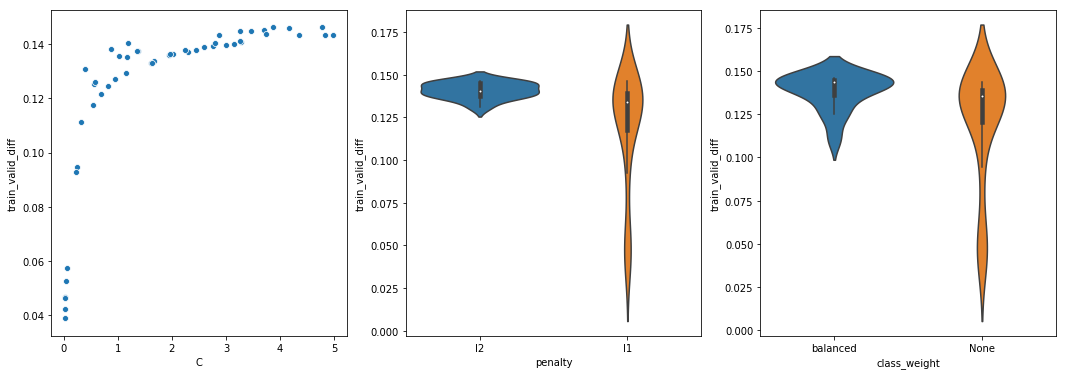

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

f, ax = plt.subplots(figsize=(18, 6), ncols=3)
sns.scatterplot(x='C', y='train_valid_diff', data=experiments, ax=ax[0])
sns.violinplot(x='penalty', y='train_valid_diff', data=experiments, ax=ax[1])
sns.violinplot(x='class_weight', y='train_valid_diff', data=experiments, ax=ax[2])

Best subset of parameters.

In [19]:
resnet18_best_params = clf_optim.space_eval(trials.best_trial)

In [20]:
%%time
clf = LinearSVC(
    max_iter=20000,
    random_state=42,
    dual=False,
    verbose=1
).set_params(**resnet18_best_params)
clf.fit(X_resnet18, y_resnet18)

[LibLinear]CPU times: user 6min 59s, sys: 2.8 s, total: 7min 2s
Wall time: 7min 29s


In [21]:
X_resnet18_test, y_resnet18_test = np.load('../data/X_resnet18_test.npy'), np.load('../data/y_resnet18_test.npy')

In [22]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

for x_i, y_i in zip([X_resnet18, X_resnet18_test], [y_resnet18, y_resnet18_test]):
    y_pred = clf.predict(x_i)
    print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
        acc=accuracy_score(y_i, y_pred),
        bal_acc=balanced_accuracy_score(y_i, y_pred)
    ))

Accuracy: 0.85285. Balanced accuracy: 0.82905
Accuracy: 0.80200. Balanced accuracy: 0.80200


# ResNet50

In [26]:
EXPERIMENT_NAME = 'resnet50_svm'

In [27]:
X_resnet50, y_resnet50 = np.load('../data/X_resnet50.npy'), np.load('../data/y_resnet18.npy')

In [28]:
import hyperopt
from hyperopt import tpe, fmin, hp, Trials, STATUS_OK

space = dict()
space['penalty'] = hp.choice('penalty', ['l1', 'l2'])
space['class_weight'] = hp.choice('class_weight', [None, 'balanced'])
space['C'] = hp.uniform('C', 0.0001, 0.1)

In [29]:
%%skip $IMPATIENCE
import warnings
warnings.filterwarnings("ignore")
from tmle.model_selection import ClassifierOptimizer
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

clf_optim = ClassifierOptimizer(
    classifier=LinearSVC(max_iter=20000, random_state=42, verbose=1, dual=False),
    space=space,
    metric=balanced_accuracy_score
)
clf_optim.find_best_params(
    X_resnet50,
    y_resnet50,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=50,
    overfit_penalty=0.1
)

In [30]:
%%time
clf = LinearSVC(
    max_iter=20000,
    random_state=42,
    dual=False,
    verbose=1
).set_params(**resnet18_best_params)
clf.fit(X_resnet50, y_resnet50)

[LibLinear]CPU times: user 11min 56s, sys: 7.36 s, total: 12min 4s
Wall time: 12min 49s


In [31]:
X_resnet50_test, y_resnet50_test = np.load('../data/X_resnet50_test.npy'), np.load('../data/y_resnet50_test.npy')

In [32]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score

for x_i, y_i in zip([X_resnet50, X_resnet50_test], [y_resnet50, y_resnet50_test]):
    y_pred = clf.predict(x_i)
    print('Accuracy: {acc:.5f}. Balanced accuracy: {bal_acc:.5f}'.format(
        acc=accuracy_score(y_i, y_pred),
        bal_acc=balanced_accuracy_score(y_i, y_pred)
    ))

Accuracy: 0.88401. Balanced accuracy: 0.86142
Accuracy: 0.84500. Balanced accuracy: 0.84500


XGBoost on ResNet50.

In [33]:
EXPERIMENT_NAME = 'resnet50_xgb'

In [34]:
from xgboost import XGBClassifier

space = dict()
space['max_depth'] = hp.choice('max_depth', np.arange(2, 8, 1))
space['learning_rate'] = hp.uniform('learning_rate', 0.001, 0.1)
space['n_estimators'] = hp.choice('n_estimators', np.arange(50, 500, 50))
space['min_child_weight'] = hp.choice('min_child_weights', [1, 5, 25])
space['subsample'] = hp.uniform('subsample', 0.5, 1.)
space['colsample_bytree'] = hp.uniform('colsample_bytree', 0.2, 0.85)
space['colsample_bylevel'] = hp.uniform('colsample_bylevel', 0.2, 0.85)

In [35]:
%%skip %IMPATIENCE
clf_optim = ClassifierOptimizer(
    classifier=XGBClassifier(n_jobs=-1, random_state=42, verbose=1),
    space=space,
    metric=balanced_accuracy_score
)
clf_optim.find_best_params(
    X_resnet50,
    y_resnet50,
    experiments_path='../experiments/',
    experiments_name=EXPERIMENT_NAME,
    max_evals=1,
    overfit_penalty=0.1
)

SyntaxError: invalid syntax (<string>, line 1)

# ResNet18 Finetuning

In [ ]:
from tmle.models import TransferLearning

In [ ]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 10)

resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 10)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.001)

In [ ]:
train_dataset = ImageFoldersDataset(
    path_to_data='/content/gdrive/My Drive/Colab Notebooks/cpu/train/',
    transform=basic_transforms
)
test_dataset = ImageFoldersDataset(
    path_to_data='/content/gdrive/My Drive/Colab Notebooks/cpu/test/',
    transform=basic_transforms
)

In [ ]:
tl_manager = TransferLearning(
    experiments_path='/content/gdrive/My Drive/Colab Notebooks/',
    experiments_name='resnet18_v3'
)

In [ ]:
%%skip $IMPATIENCE
tl_manager.train(
     model=resnet18,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=5,
     batch_size=32,
     shuffle=True
)

In [ ]:
model = resnet18
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/Colab Notebooks/resnet18_v3.pth')

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
tl_manager_finetuning = TransferLearning(
    experiments_path='/content/gdrive/My Drive/Colab Notebooks/',
    experiments_name='resnet18_5_10_epoch_v3'
)

In [ ]:
%%skip $IMPATIENCE
tl_manager_finetuning.train(
     model=model,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=5,
     batch_size=32,
     shuffle=True
)

In [ ]:
model = resnet18
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.99)

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/Colab Notebooks/resnet18_5_10_epoch_v3.pth')

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
tl_manager_finetuning_2 = TransferLearning(
    experiments_path='/content/gdrive/My Drive/Colab Notebooks/',
    experiments_name='resnet18_10_20_epoch_v3'
)

In [ ]:
%%skip $IMPATIENCE
tl_manager_finetuning.train(
     model=model,
     criterion=criterion,
     optimizer=optimizer,
     train_dataset=train_dataset,
     test_dataset=valid_dataset,
     n_epochs=5,
     batch_size=32,
     shuffle=True
)